In [1]:
#   this Notebook is example of Portfolio aggregation using : 
##  user defined function 
##  using Tree  as classifier, that 
##  represents hierarchical structure of stock sector 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import Columns as CL
from mtree import MTree
from aggr_func import vw_aggr

plt.style.use('seaborn')
sns.set()

In [3]:
##   Read SP  500 portfolio 

In [4]:
port = pd.read_csv('./data/constituents-financials.csv', index_col=0)
# calculate weigth of market value of stock in index 
port[CL.WEIGHT] = port[CL.MARKET_CAP] / port[CL.MARKET_CAP].sum()
weight_sector = port.groupby(CL.SECTOR)[CL.WEIGHT].sum()
port.head()

,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,Weight
Symbol,,,,,,,,,,,,,,
MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,138721055226,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.005579
AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,10783419933,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.000434
ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,102121042306,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.004107
ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,181386347059,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.007295
ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,98765855553,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.003972


In [5]:
weight_total = weight_sector.sum()
print('weight_sectors')
print(weight_sector)
weight_sector
print('weight_total {} '.format( weight_total))

weight_sectors
Sector
Consumer Discretionary        0.129236
Consumer Staples              0.083933
Energy                        0.054585
Financials                    0.138449
Health Care                   0.130474
Industrials                   0.096982
Information Technology        0.270536
Materials                     0.027841
Real Estate                   0.025148
Telecommunication Services    0.018219
Utilities                     0.024597
Name: Weight, dtype: float64
weight_total 0.9999999999999999 


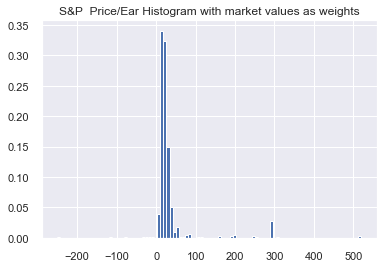

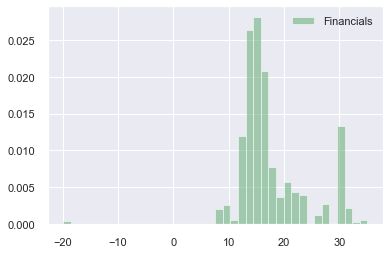

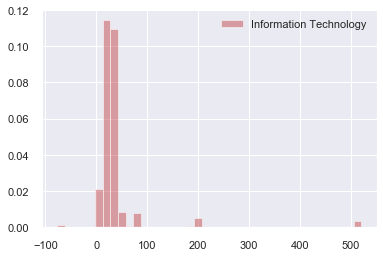

In [6]:
SP = 'S&P  Price/Ear Histogram with market values as weights'
port_cl = port.dropna(subset=[CL.PRICE_EARN])
plt.figure()
plt.title(SP)
plt.his
kwargs = dit(port_cl[CL.PRICE_EARN], 100, weights=port_cl[CL.WEIGHT])
ct(alpha=0.5, bins=40)
# select Financials stocks
col = 'Financials'
pe_ratio = port.loc[port['Sector'] == col, [CL.WEIGHT, CL.PRICE_EARN]]  
# show histogram with weights based on Market Values
plt.figure()
plt.hist(pe_ratio[CL.PRICE_EARN],  **kwargs, color='g', label=col, weights=pe_ratio[CL.WEIGHT])
plt.legend()

# select Information Technology stocks
col = 'Information Technology'
pe_ratio = port.loc[port['Sector'] == col, [CL.WEIGHT, CL.PRICE_EARN]]
plt.figure()
# show histogram with weights based on Market Values
plt.hist(pe_ratio[CL.PRICE_EARN],  **kwargs, color='r', label=col, weights=pe_ratio[CL.WEIGHT])
plt.legend()

###  Using custom aggregation function for portfolio

In [7]:
def aggregate_port(group: pd.DataFrame, group_cols) -> pd.DataFrame:  
    """  
    :param group: GroupByDataFrame
    :param group_cols: columns that are used in splitting rows
    :return: DataFrame is result of aggregation
    """
    # dct dictionary represents columns and aggregation values 
    dct = {
        '%' + CL.WEIGHT:  group[CL.WEIGHT].sum() * 100, 
        CL.WEIGHT: group[CL.WEIGHT].sum(),
       'COUNT': group[CL.NAME].count(),
        CL.PRICE: vw_aggr(group, CL.PRICE),
        CL.PRICE_EARN: vw_aggr(group, CL.PRICE_EARN),
        CL.PRICE_SALES: vw_aggr(group, CL.PRICE_SALES),
        CL.PRICE_BOOK: vw_aggr(group, CL.PRICE_BOOK),
        CL.DIV_YIELD: vw_aggr(group, CL.DIV_YIELD),
        CL.EBITDA: vw_aggr(group, CL.EBITDA)
        }
    
    # add columns for keys used in aggregation
    for cl in group_cols:
        dct[cl] = group.iloc[0][cl]
    return pd.DataFrame([dct])


df_aggr = port.groupby(CL.SECTOR).apply(lambda x: aggregate_port(x, ['Sector']))

### Build classifier for hierarchical tree aggregation
###  Tree represents hierarchical structure of stock sector 

In [8]:
## load json to dictionary tree
with open('./data/SectorTree.json') as json_file:
    tree = json.load(json_file)
# load json data to MTree, which is hierarchical representation of Sectors
m_tree = MTree()
for node in tree:
    m_tree.add_node(node)

# returns list of all terminal nodes id 
term_nodes = m_tree.get_term_nodes()
aggr_key = 'Sector'
classifier_rows = []
for key in term_nodes:
    # for each of terminal node id returns list of nodes id from term node to its top parent
    #  { ENE :  [ENE_IND_MAT], IND : [ENE_IND_MAT], MAT: [ENE_IND_MAT]....
    path = m_tree.get_node_path(key)
    name = m_tree.get_node(key).get_name()
    # Convert list ['ENE',''ENE_IND_MAT']  to dict {'SECTOR-0': 'ENE_IND_MAT', 'SECTOR-1': 'ENE} 
    row = m_tree.node2row(aggr_key, path)
    row[aggr_key] = name
    classifier_rows.append(row)
# classifier is DataFrame representation of the  Sector tree 
df_classifier = pd.DataFrame.from_records(classifier_rows)  
print('===================')
print(df_classifier.info())
# fill columns with null values from previous column Sector-1 from Sector-0 
df_classifier.loc[df_classifier[aggr_key + '-1'].isnull(), aggr_key + '-1'] = df_classifier[aggr_key + '-0']
print ('Classifier')
df_classifier

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
Sector      11 non-null object
Sector-0    11 non-null object
Sector-1    8 non-null object
dtypes: object(3)
memory usage: 344.0+ bytes
None
Classifier


,Sector,Sector-0,Sector-1
0,Consumer Staples,Consumer,Consumer Staples
1,Consumer Discretionary,Consumer,Consumer Discretionary
2,Industrials,Industry/Materials,Industrials
3,Materials,Industry/Materials,Materials
4,Information Technology,Info Tech. Telecom.,Information Technology
5,Telecommunication Services,Info Tech. Telecom.,Telecommunication Services
6,Energy,Energy Uilities,Energy
7,Utilities,Energy Uilities,Utilities
8,Financials,Financials,Financials
9,Health Care,Health Care,Health Care


In [9]:
## Sector classifier

In [10]:
df_merge = pd.merge(port, df_classifier, left_on='Sector', right_on='Sector')

aggr_keys = ['Sector-0', 'Sector-1']
aggr_key = aggr_keys
df_report = df_merge.groupby(aggr_key, as_index=False).apply(lambda x: aggregate_port(x, aggr_key))
aggr_key = ['Sector-0']
sub_total_col = 'Sector-1'
df_report_0 = df_merge.groupby(aggr_key, as_index=False).apply(lambda x: aggregate_port(x, aggr_key))
#row header for total values for Sector 0
df_report_0[sub_total_col] = 'SubTotal-'
df_report = pd.concat([df_report, df_report_0], sort=False)
df_report.reset_index()
df_report.set_index(aggr_keys, inplace=True)
df_report.sort_index(inplace=True)

## Sector based Aggregation Report

In [11]:
df_report

%Weight  COUNT  \
Sector-0            Sector-1                                       
Consumer            Consumer Discretionary      12.923565     84   
                    Consumer Staples             8.393322     34   
                    SubTotal-                   21.316887    118   
Energy Uilities     Energy                       5.458531     32   
                    SubTotal-                    7.918254     60   
                    Utilities                    2.459723     28   
Financials          Financials                  13.844853     68   
                    SubTotal-                   13.844853     68   
Health Care         Health Care                 13.047414     61   
                    SubTotal-                   13.047414     61   
Industry/Materials  Industrials                  9.698180     67   
                    Materials                    2.784133     25   
                    SubTotal-                   12.482313     92   
Info Tech. Telecom. Information Technology      27.053586     70   
                    SubTotal-                   28.875528     73   
                    Telecommunication Services   1.821943      3   
Real Estate         Real Estate                  2.514750     33   
                    SubTotal-                    2.514750     33   

                                                Dividend Yield        EBITDA  \
Sector-0            Sector-1                                                   
Consumer            Consumer Discretionary            0.167894  1.304255e+09   
                    Consumer Staples                  0.227329  9.689217e+08   
                    SubTotal-                         0.395223  2.273176e+09   
Energy Uilities     Energy                            0.160271  8.775385e+08   
                    SubTotal-                         0.253111  1.001818e+09   
                    Utilities                         0.092840  1.242790e+08   
Financials          Financials                        0.255285  5.591629e+07   
                    SubTotal-                         0.255285  5.591629e+07   
Health Care         Health Care                       0.218171  1.152541e+09   
                    SubTotal-                         0.218171  1.152541e+09   
Industry/Materials  Industrials                       0.180174  5.414636e+08   
                    Materials                         0.053197  9.570637e+07   
                    SubTotal-                         0.233372  6.371700e+08   
Info Tech. Telecom. Information Technology            0.290492  7.212259e+09   
                    SubTotal-                         0.387873  8.051878e+09   
                    Telecommunication Services        0.097380  8.396186e+08   
Real Estate         Real Estate                       0.091772  4.834317e+07   
                    SubTotal-                         0.091772  4.834317e+07   

                                                    Price  Price/Book  \
Sector-0            Sector-1                                            
Consumer            Consumer Discretionary      54.156961    3.836130   
                    Consumer Staples             7.171608    9.372723   
                    SubTotal-                   61.328569   13.208853   
Energy Uilities     Energy                       4.094839    0.119050   
                    SubTotal-                    5.743121    0.169331   
                    Utilities                    1.648282    0.050281   
Financials          Financials                  14.172920    0.476060   
                    SubTotal-                   14.172920    0.476060   
Health Care         Health Care                 16.977773    0.913137   
                    SubTotal-                   16.977773    0.913137   
Industry/Materials  Industrials                 14.918725    2.345510   
                    Materials                    3.013745    0.126498   
                    SubTotal-                   17.932470    2.472